Travail réalisé par Aginth Muthulingam 

## Chargement des modules

In [38]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from function import *


from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV , cross_validate
from sklearn.compose import make_column_selector, make_column_transformer , ColumnTransformer
from category_encoders import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import linear_model , metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score

## Chargement base de données

In [39]:
df_clean = pd.read_csv('dataset_cleane.csv')
df_clean = df_clean.drop(['SiteEnergyUseWN(kBtu)_log'],axis=1)

## Skewness

Nous avons une skewness relativement élévé pour plusieurs variable , il serait donc judicieux de les passer au log les variable ayant une skewness > 2 afin de voir si cela peut améliorer la performance de nos modèles 

In [41]:
df_clean_log = log_transform (df_clean)
df_clean_log.skew(axis = 0, skipna = True).sort_values(ascending=False)

PropertyUseType__Wholesale Club/Supercenter               32.603681
PropertyUseType__Convenience Store without Gas Station    32.603681
PropertyUseType__Other - Education                        32.603681
PropertyUseType__Other - Recreation                       32.603681
PropertyUseType__Manufacturing/Industrial Plant           32.603681
PropertyUseType__Other - Restaurant/Bar                   32.603681
PropertyUseType__Self-Storage Facility                    32.603681
PropertyUseType__Pre-school/Daycare                       32.603681
PropertyUseType__Performing Arts                          32.603681
PropertyUseType__Bar/Nightclub                            32.603681
PropertyUseType__Other - Services                         32.603681
PropertyUseType__College/University                       32.603681
PropertyUseType__Courthouse                               32.603681
PropertyUseType__Adult Education                          32.603681
PropertyUseType__Other - Entertainment/Public As

## Modélisation 

la variable qu'on souhaite prédire est :
- TotalGHGEmissions_log

### Mise en place des modèles 

In [42]:
# Features : all columns, except targets
X = df_clean.copy().drop(columns=['TotalGHGEmissions_log','ENERGYSTARScore'])
X_log = df_clean_log.copy().drop(columns=['TotalGHGEmissions_log','ENERGYSTARScore']) 

cible2 = 'TotalGHGEmissions_log'

y = df_clean.copy()[cible2]
y_log = df_clean_log.copy()[cible2]

In [43]:
numerical_feature = make_column_selector(dtype_include=np.number)
categorical_feature = make_column_selector(dtype_exclude=np.number)

In [44]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [45]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_feature),
                                               ('cat', categorical_transformer, categorical_feature)])

In [46]:
#baseline 
dummy = Pipeline(steps=[('prepa',preprocessor),('dummy',DummyRegressor())])

# Modele à tester

linear = Pipeline(steps=[('prepa',preprocessor),('linear',linear_model.LinearRegression())])
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])

forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])
ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0,))])
MLPr = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(random_state=0,max_iter=10000))])

In [47]:
ls_model = [dummy,linear,KNN,forest,ADA,MLPr]
dico_model = {0: "dummy", 1: "lr",2:'KNN',3:'forest',4:'adaboost',5:"Multi Layer Perceptron"}

### Comparaison avec variables normal vs variables log

In [48]:
analyse_un = analyse_modele (X,y,ls_model,dico_model)
analyse_un_log = analyse_modele (X_log,y_log,ls_model,dico_model)

In [49]:
analyse_un

,RMSE,MAE,R2
dummy,1.390852,1.130045,-0.441166
lr,126.295637,72.105794,-24210.560723
KNN,1.114956,0.877215,0.082778
forest,0.899496,0.711367,0.403943
adaboost,0.979836,0.806152,0.297514
Multi Layer Perceptron,1.050659,0.814500,0.195088


In [50]:
analyse_un_log

,RMSE,MAE,R2
dummy,1.390852,1.130045,-0.441166
lr,37.459953,23.794542,-2168.015564
KNN,1.037817,0.817111,0.205443
forest,0.899328,0.711093,0.404227
adaboost,0.983600,0.813147,0.292406
Multi Layer Perceptron,0.901695,0.718799,0.402057


lr semble trop incohérent

In [51]:
analyse_un.drop('lr',inplace=True)
analyse_un_log.drop('lr',inplace=True)


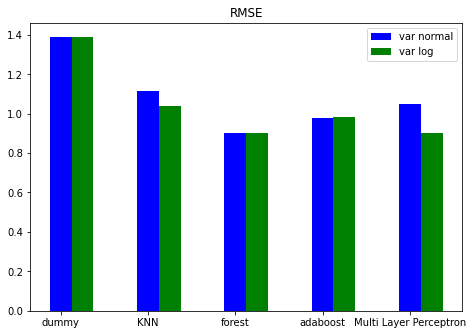

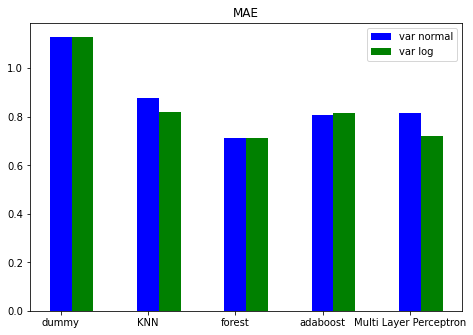

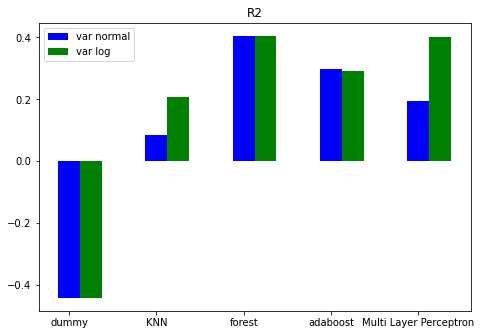

In [52]:
for i in analyse_un.columns : 
    plot_metrics1 (analyse_un,analyse_un_log,i)

### Recherche hyperparamètres modèles

In [16]:
# On splite les données 
X_train, X_test, y_train, y_test = train_test_split(X_log, y,test_size=0.2,random_state=0)

#### Random Forest

In [ ]:
params_forest = {"forest__n_estimators" : list(np.arange(120,140)),
                 'forest__min_samples_leaf': list(np.arange(1,5)),
                 'forest__max_depth' : list(np.arange(5,20))
}

forest_cv = GridSearchCV(forest,params_forest,cv=7)
forest_cv = forest_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(forest_cv.best_params_))
print("Best score: {}".format(forest_cv.best_score_))

In [54]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=125, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

score = cross_validate(forest_max,X_log,y,cv=7,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_forest = -score['test_neg_root_mean_squared_error'].mean()
r2_forest = score['test_r2'].mean()
msa_forest = -score['test_neg_mean_absolute_error'].mean()

result_forest = [rmse_forest,msa_forest,r2_forest]
result_forest 

[0.8844203602611315, 0.6989304588340259, 0.40481623162926855]

#### KNN

In [ ]:
params_kNN = {"kNN__n_neighbors" : list(np.arange(3,20)),
              'kNN__leaf_size' : list(np.arange(1,40)),
              'kNN__p' : [1,2]
}

kNN_cv = GridSearchCV(KNN,params_kNN,cv=4)
kNN_cv = kNN_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(kNN_cv.best_params_))
print("Best score: {}".format(kNN_cv.best_score_))



In [55]:
kNN_max = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor(n_neighbors=12, p =1,
                                                                            leaf_size=1
                                                                              ))])

score = cross_validate(kNN_max,X_log,y,cv=4,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_knn = -score['test_neg_root_mean_squared_error'].mean()
r2_knn = score['test_r2'].mean()
msa_knn = -score['test_neg_mean_absolute_error'].mean()

result_knn = [rmse_knn,msa_knn,r2_knn]
result_knn

[1.0294633665255488, 0.8159505916402888, 0.21735262841398956]

#### Adaboost

In [ ]:
params_ADA={"ADA__n_estimators" : list(np.arange(1,80)),
            "ADA__loss" : ['linear', 'square', 'exponential']   
}

ADA_cv = GridSearchCV(ADA, params_ADA, cv =4)
ADA_cv = ADA_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(ADA_cv.best_params_))
print("Best score: {}".format(ADA_cv.best_score_))

#Temps = 38min 

In [56]:
ADA_max = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(n_estimators = 43, loss = 'linear', 
                                                                          random_state=0,))])
score = cross_validate(ADA_max,X_log,y,cv=4,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_ada = -score['test_neg_root_mean_squared_error'].mean()
r2_ada = score['test_r2'].mean()
msa_ada = -score['test_neg_mean_absolute_error'].mean()

result_ada = [rmse_ada,msa_ada,r2_ada]
result_ada

[0.9872158720576963, 0.8169065230279283, 0.2876142433658432]

#### Multi Layer Perceptron

In [75]:
params_MLPr={"MLPr__hidden_layer_sizes" : list(np.arange(100,128)),
            "MLPr__activation" : ['identity', 'logistic']
} #, 'tanh', 'relu'

MLPr_cv = GridSearchCV(MLPr, params_MLPr, cv =7)
MLPr_cv = MLPr_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(MLPr_cv.best_params_))
print("Best score: {}".format(MLPr_cv.best_score_))

Best Parameters: {'MLPr__activation': 'logistic', 'MLPr__hidden_layer_sizes': 104}
Best score: 0.5631781240317411


In [107]:
MLPr_max = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(hidden_layer_sizes = 104, activation = 'logistic', 
                                                                          random_state=0,max_iter=10000))])

score = cross_validate(MLPr_max,X_log,y,cv=7,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_MLPr = -score['test_neg_root_mean_squared_error'].mean()
r2_MLPr = score['test_r2'].mean()
msa_MLPr = -score['test_neg_mean_absolute_error'].mean()

result_MLPr = [rmse_MLPr,msa_MLPr,r2_MLPr]
print(result_MLPr) 
# 81       0.4013

[0.8786467338153309, 0.7066489696602946, 0.4091198671056918]


### Comparaison des modèles

In [108]:
analyse_un_log2 = analyse_un_log.copy().drop('dummy')

In [109]:
analyse_opt = pd.DataFrame([result_knn, result_forest, result_ada,result_MLPr],columns = ['RMSE','MAE','R2'],
                           index = ['KNN','forest','adaboost','Multi Layer Perceptron'])

In [110]:
analyse_opt

,RMSE,MAE,R2
KNN,1.029463,0.815951,0.217353
forest,0.884420,0.698930,0.404816
adaboost,0.987216,0.816907,0.287614
Multi Layer Perceptron,0.878647,0.706649,0.409120


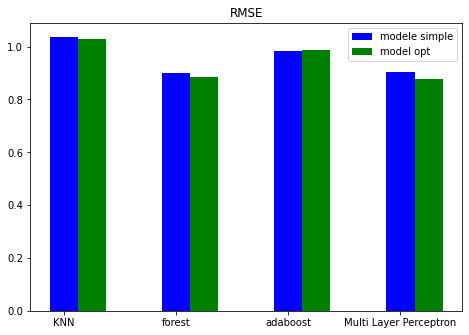

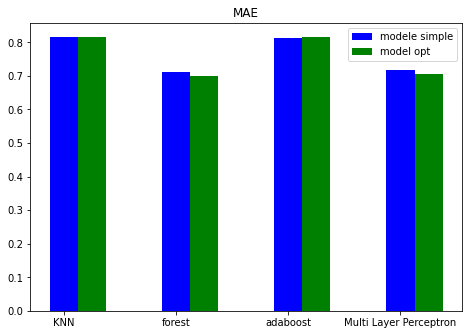

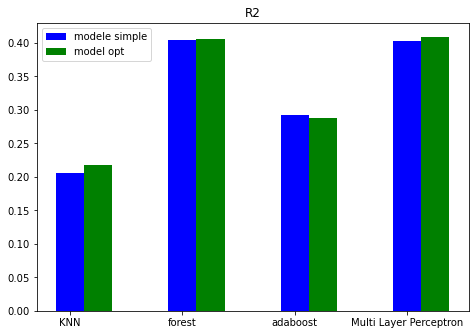

In [111]:
for i in analyse_un_log2.columns :
    plot_metrics2 (analyse_un_log2,analyse_opt,i)

## Modèle choisi : Multi Layer Perceptron

### Feature importance 

#### Methode 1 : Permutation Importance

In [127]:
MLPr_max.fit(X_train,y_train)

perm_importance = permutation_importance(MLPr_max, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

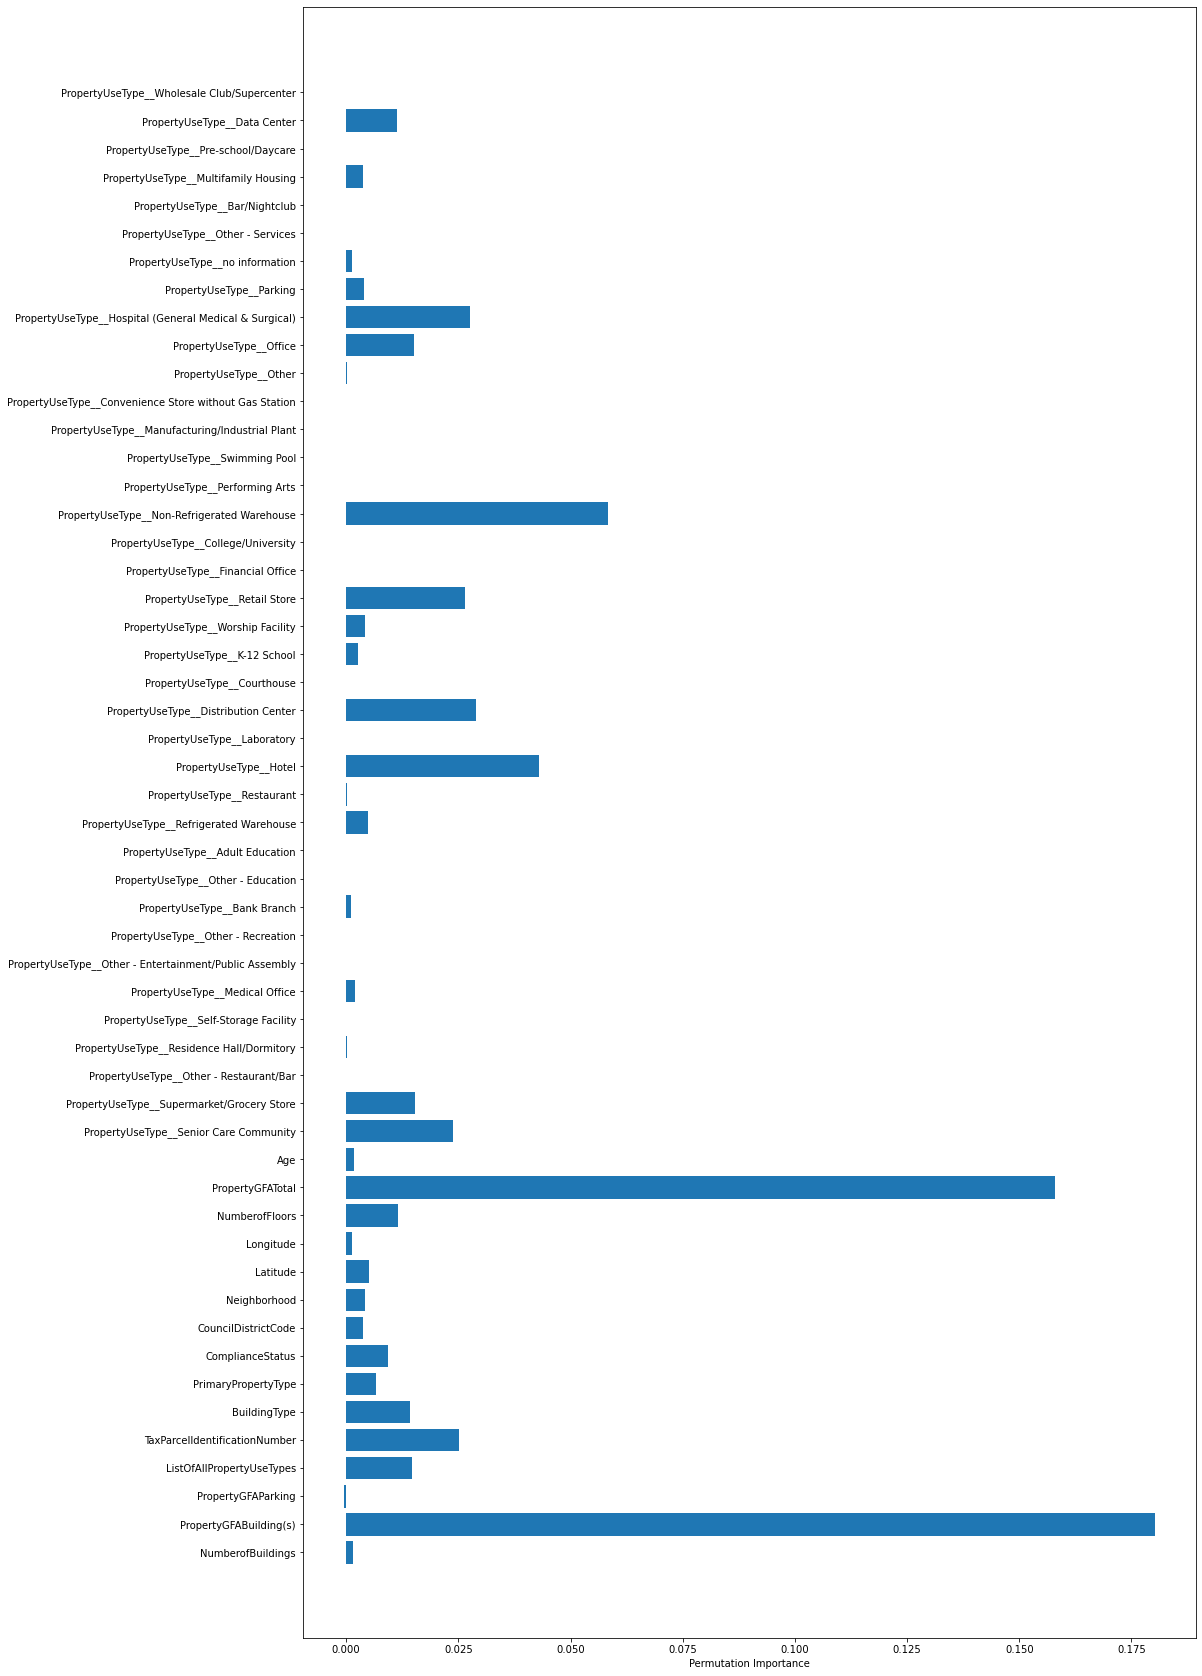

In [128]:
plt.figure(figsize=(16, 30))
plt.barh(X_train.columns, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

### Importance de la var ENERGYSTARScore

In [77]:
df_fin = df_clean_log

In [78]:
X=df_fin.copy().drop(['ENERGYSTARScore',cible2],axis=1)
y = df_fin[cible2]

In [79]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,test_size=0.2,random_state=0)

In [93]:
MLPr_max = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(hidden_layer_sizes =105, activation = 'logistic', 
                                                                          random_state=0,max_iter = 10000 ))]) #109

MLPr_max = MLPr_max.fit (X_train2, y_train2)
y_pred = MLPr_max.predict(X_test2)

MLPr_max.score(X_test2, y_test2)

ls_m = np.array([mean_squared_error(y_test2, y_pred, squared=False),
mean_absolute_error(y_test2, y_pred),
r2_score(y_test2, y_pred)])

df_sansES = pd.DataFrame(ls_m,index=['RMSE','MAE','R2'],columns=['Sans ENERGYSTARScore']).T
df_sansES

,RMSE,MAE,R2
Sans ENERGYSTARScore,0.914181,0.739639,0.508117


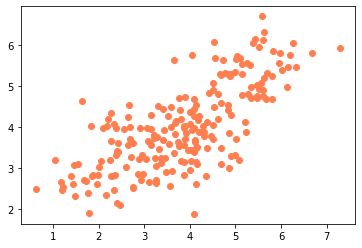

In [81]:
plt.scatter(y_test2, y_pred, color='coral')

**Avec Energy Score**

In [94]:
df_fin2= df_clean_log

X2=df_fin2.copy().drop([cible2],axis=1)
X2=X2[X2['ENERGYSTARScore']>0]

In [95]:
X_train2b, X_test2b, y_train2b, y_test2b = train_test_split(X2, y,test_size=0.2,random_state=0)

In [101]:
MLPr_max = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(hidden_layer_sizes =105, activation = 'logistic', 
                                                                          random_state=0,max_iter = 10000 ))]) #119

MLPr_max = MLPr_max.fit (X_train2b, y_train2b)
y_pred = MLPr_max.predict(X_test2b)

MLPr_max.score(X_test2b, y_test2b)

ls_m = np.array([mean_squared_error(y_test2b, y_pred, squared=False),
mean_absolute_error(y_test2b, y_pred),
r2_score(y_test2b, y_pred)])

df_avecES = pd.DataFrame(ls_m,index=['RMSE','MAE','R2'],columns=['Avec ENERGYSTARScore']).T
df_avecES

,RMSE,MAE,R2
Avec ENERGYSTARScore,0.859981,0.689064,0.564713


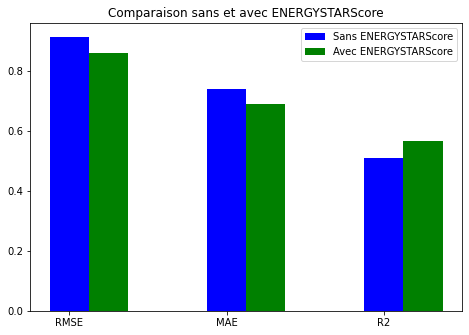

In [97]:
plot_metrics3(df_sansES,df_avecES)

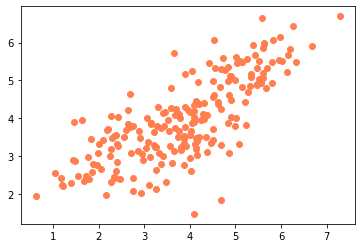

In [72]:
plt.scatter(y_test2b, y_pred, color='coral')

[ 77 155 233 311 389 467 545 623 701 779]


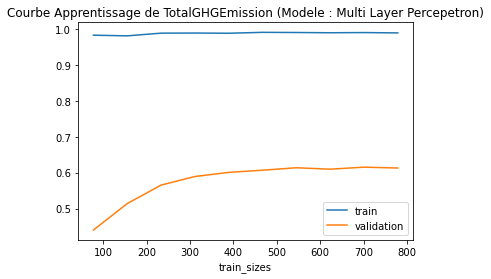

In [106]:
from sklearn.model_selection import learning_curve
MLPr_max = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(hidden_layer_sizes =109, activation = 'logistic', 
                                                                          random_state=0,max_iter = 10000 ))])

N, train_score, val_score = learning_curve(MLPr_max, X_train2b, y_train2b,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=12)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Courbe Apprentissage de TotalGHGEmission (Modele : Multi Layer Percepetron)')
plt.legend()